In [418]:
import pandas as pd
import numpy as np
import csv
from nltk.corpus  import stopwords
from nltk.stem.porter import PorterStemmer
import seaborn as sns
import pickle as pk
import matplotlib.pyplot as plt
import re
import os

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
# determine the optimal cluster for kmeans 


All Dang
Number of reviews: 2373
75.000000 perc 5 star, 85.000000 perc positive, 9.000000 perc negative, 4.451749 mean


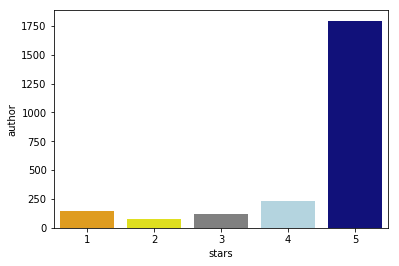

Bars Data
Number of reviews: 356
64.000000 perc 5 star, 76.000000 perc positive, 18.000000 perc negative, 4.078652 mean


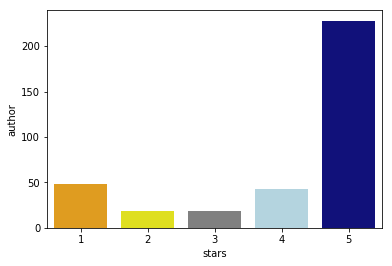

Bar: Almond Vanilla
Number of reviews: 11
72.000000 perc 5 star, 90.000000 perc positive, 9.000000 perc negative, 4.454545 mean


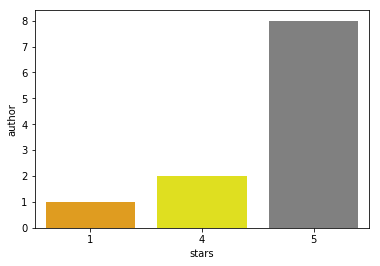

Bar: Caramom Chai
Number of reviews: 5
60.000000 perc 5 star, 60.000000 perc positive, 20.000000 perc negative, 3.800000 mean


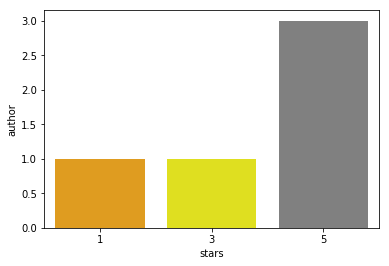

Bar: Chocolate Sea Salt
Number of reviews: 36
50.000000 perc 5 star, 61.000000 perc positive, 30.000000 perc negative, 3.527778 mean


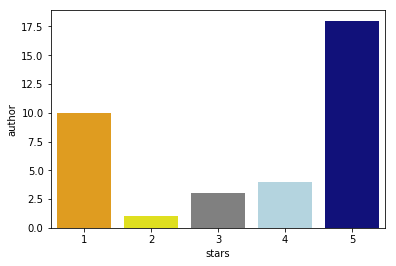

Bar: Lemon Matcha
Number of reviews: 34
82.000000 perc 5 star, 91.000000 perc positive, 5.000000 perc negative, 4.617647 mean


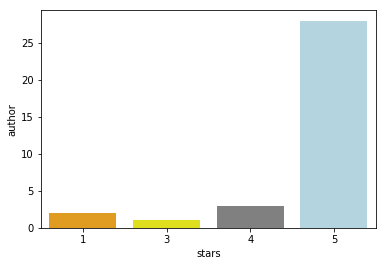

Bar: Saigon Cinnamon Chocolate
Number of reviews: 1
100.000000 perc 5 star, 100.000000 perc positive, 0.000000 perc negative, 5.000000 mean


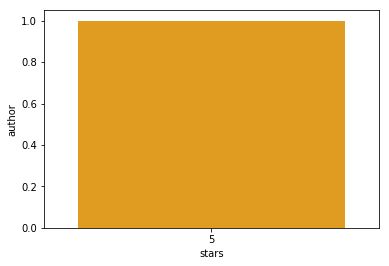

Bar: Toasted Coconut
Number of reviews: 6
50.000000 perc 5 star, 83.000000 perc positive, 16.000000 perc negative, 4.166667 mean


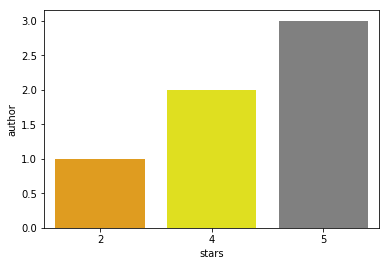

Bar: Variety Pack - 3
Number of reviews: 220
63.000000 perc 5 star, 75.000000 perc positive, 19.000000 perc negative, 4.059091 mean


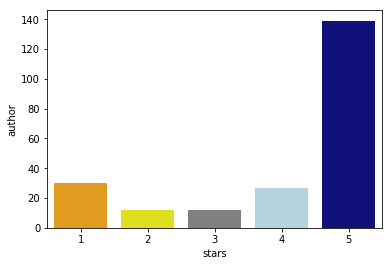

Bar: Variety Pack - 6
Number of reviews: 43
65.000000 perc 5 star, 76.000000 perc positive, 20.000000 perc negative, 4.116279 mean


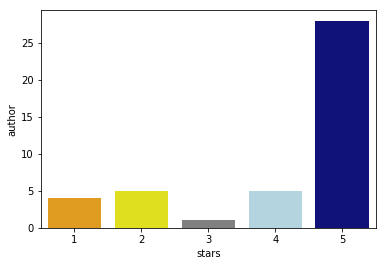

Bar:  Not Chocolate
Number of reviews: 43
65.000000 perc 5 star, 76.000000 perc positive, 20.000000 perc negative, 4.116279 mean


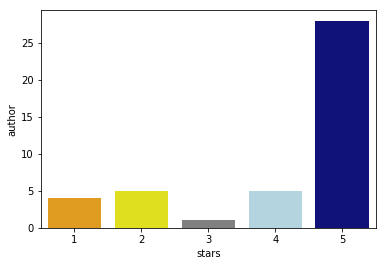

In [408]:
def readFile(file_name):
    reader = open(file_name, 'r',  errors = 'ignore')
    csvreader = csv.reader(reader, delimiter = ',')
    data = []
    colnames = csvreader.__next__()
    for row in csvreader:
        data.append(row)
    return pd.DataFrame(data, columns = colnames)
    

def ratingDistribution(data):
    plt.figure()
    stars = np.array([float(r) for r in data['stars']])
    len_stars = len(stars)
    perc_fivestar = int(np.sum(stars == 5)*100/len_stars)
    perc_positive = int(np.sum(stars >= 4)*100/len_stars)
    perc_negative = int(np.sum(stars <= 2)*100/len_stars)
    rating_mean = np.mean(stars)
    ratings_count = data.groupby('stars').count()['author'].reset_index()
    print('Number of reviews: %i' % (len_stars))
    print('%f perc 5 star, %f perc positive, %f perc negative, %f mean' % (
        perc_fivestar, perc_positive, perc_negative, rating_mean))
    sns.barplot(x = 'stars', y= 'author', data= ratings_count, 
                palette = ['orange','yellow','grey','lightblue','darkblue'])
    plt.show()
    
    
def plotRatings(data):
    print('All Dang')
    ratingDistribution(data)
    print('Bars Data')
    bars_data = data[data['Category_custom'] == 'Bars']
    ratingDistribution(bars_data)
    for flavor in np.unique(bars_data.Flavor_custom):
        flavor_data = bars_data[bars_data.Flavor_custom == flavor]
        print('Bar: ' + flavor)
        ratingDistribution(flavor_data)
    notchocolate_data = bars_data[bars_data.Flavor_custom != 'Chocolate Sea Salt']
    print('Bar:  Not Chocolate')
    ratingDistribution(flavor_data)
    

file_name = 'reviews.csv'
data = readFile(file_name)

# ratingDistribution(data)
plotRatings(data)
# Plot the distribution of ratings 
# by type 
# by bar flavor 
#

In [340]:
np.sum(data.stars == '5')/len(data.stars)

0.7564264643910662

In [436]:

    
class TokenizeData:
    
    def __init__(self):
        # self.stemmer = stemmer
        self.stop_words = stopwords.words('english')
        self.token_dict = {}
        self.token_index_dict = {}
        # self.stem_dict = {}
        self.tokenize_arrays = []


    def createTokenizeData(self, data):
        self.max_index = 0
        for i, row in data.iterrows():
            row_text = row.text
            row_string = re.sub(r'[\.\,!;]',"", row_text)
            row_text_arr = row_string.split(' ')
            self.createTokenizeArr(row_text_arr)
        print('max index %i' % (self.max_index))

    def createTokenizeArr(self, array):
        tokenize_arr = []
        for word in array:
            # (1) remove stop words 
            stemmed_word = self.editWord(word)
            # self.stem_dict[stemmed_word]  = self.stem_dict.get(stemmed_word, set())
            # self.stem_dict[stemmed_word].add(word)
            if stemmed_word not in self.stop_words:
                if stemmed_word not in self.token_dict:
                    self.max_index+=1
                    self.token_dict[stemmed_word] = self.max_index
                    self.token_index_dict[self.max_index] = stemmed_word
                tokenize_arr.append(self.token_dict[stemmed_word])
        self.tokenize_arrays.append(tokenize_arr)

            
    def editWord(self, word):
        # text edit:
        # (1) stem words
        # (2) remove any non alphabet symbols  
        new_word = ''.join(re.findall(
            r"([a-zA-Z]+)", word))
        return new_word.lower()

    
    
class TFIDF:
    
    def __init__(self, tokenizer):
        self.tokenizer = tokenizer
        
    def genTfidf(self):
        '''
            generates the token count for each and the num
        '''
        max_index = self.tokenizer.max_index  
        token_arrays = self.tokenizer.tokenize_arrays 
        len_docs = len(token_arrays)
        count_mat, doc_mat = self.calcTFIDFMats(max_index, token_arrays, len_docs)
        ln_doc_count = np.log(1/np.sum(doc_mat, axis = 0))
        self.vectors = count_mat / ln_doc_count 
    
    def calcTFIDFMats(self, max_index, token_arrays, len_docs):
        '''
            Calculate the frequency of tokens in each doc along with whether the
            token appears in that doc 
            Input: tokens in each doc (review)
            Output: matrix of token appearance in doc (1 if appear 0 if not) and matrix of
                token count in doc 
        '''
        count_mat = []
        doc_mat = []
        for tokens in token_arrays:
            count_arr = [0]*max_index
            doc_arr = [0]*max_index
            for token in tokens:
                count_arr[token-1]+=1
                doc_arr[token-1]=1/len_docs
            count_mat.append(count_arr)
            doc_mat.append(doc_arr)
        return count_mat, doc_mat
        

class Embedding:
    
    def __init__(self, tokenizer):
        '''
            Initiate the path to fasttext vector files stored locally
        '''
        self.tokenizer = tokenizer
        pickle_filename = '~/FastData/wiki.en/wiki.en.pkl'
        self.pickle_path = os.path.expanduser(pickle_filename)

    def processDict(self):
        '''
            Load the fast text word dict and then
            translate to an emedding matrix
        '''
        word_vec =  self.loadWordDict()
        tokenized_word_index = self.tokenizer.token_dict
        self.creatEmbedMatrix(tokenized_word_index, word_vec)


    def loadWordDict(self):
        '''
            Load the word dictionary
        '''
        pickle_reader = open(self.pickle_path, 'rb')
        word_vec = pk.load(pickle_reader)
        return word_vec


    def creatEmbedMatrix(self, word_index, ft_word_vec ):
        '''
            convert the tokenized word indices
            into an embedding matrix where the row corresponds to the
            tokenized index, and the vector directly from fasttext
        '''
        # create an embedding matrix
        num_words = len(word_index) + 1
        # the number of dimension in a word vector
        embedding_dim = len(ft_word_vec.get('.'))
        embedding_matrix = np.zeros((num_words, embedding_dim))

        for word, i in word_index.items():
            embedding_vector = ft_word_vec.get(word)
            if embedding_vector is not None:
                # words not found in embedding index will be all-zeros.
                embedding_matrix[i] = embedding_vector
        self.embedding_matrix = embedding_matrix

    
    def createDocEmbedding(self, func):
        self.doc_embeddings = []
        for tokenize_doc in self.tokenizer.tokenize_arrays:
            embedding = self.createPool(tokenize_doc, func)
            self.doc_embeddings.append(embedding)
    
    def createPool(self, tokenize_doc, func):
        '''
            Input the token vector for all the words in a doc (review)
            and apply a function (max or average) on the vectors 
        '''
        embeddings = []
        for token in tokenize_doc:
            embeddings.append(self.embedding_matrix[token])
        doc_embedding = func(embeddings, axis=0)
        return doc_embedding
        # self.tokenizer.token_arrays

In [474]:
# print(data.columns)
# data['stars'].head()
bars_data = data[data['Category_custom'] == 'Bars']
# bars_data = bars_data[bars_data['stars']<='2']
tokenizer = TokenizeData()
tokenizer.createTokenizeData(bars_data)
embedding = Embedding(tokenizer)
embedding.processDict()
embedding.createDocEmbedding(np.max)
tfidf = TFIDF(tokenizer)
tfidf.genTfidf()

max index 1461


67

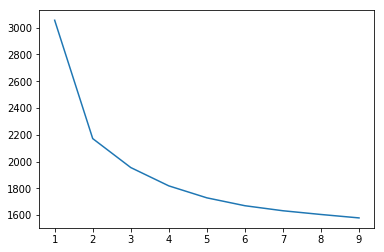

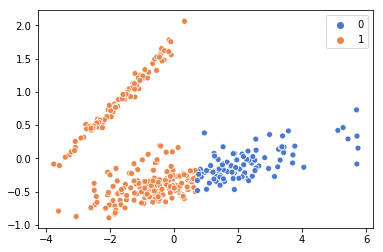

In [476]:

class KmeansCluster:
    
    def __init__(self, data):
        self.data = data 
        self.model = None
        
    def plotKmeansCluster(self, topn):
        inertias = []
        for n in range(1,topn):
            kmean = KMeans(n_clusters = n , random_state =0).fit(self.data)
            inertias.append(kmean.inertia_)
        plt.figure()
        sns.lineplot(x=range(1,topn), y=inertias)

    def genKmeans(self, ncluster):
        self.model = KMeans(n_clusters = ncluster , random_state =0).fit(self.data)
        
    def plotPCA(self):
        pca = PCA(n_components=2)
        output = pca.fit_transform(self.data)
        x1 = [x[0] for x in output]
        x2 = [x[1] for x in output]
        plt.figure()
        if self.model:
            sns.scatterplot(x1, x2, hue = self.model.labels_, 
                            palette=sns.color_palette("muted",n_colors =self.model.n_clusters))
        else:
            sns.scatterplot(x1, x2)

    def findTopWordsByGroup(self, tokenizer, tfidf):
        vectors = tfidf.vectors
        labels = self.model.labels_
        n_clusters = self.model.n_clusters
        top_word_dict = {}
        for n in range(0, n_clusters):
            cluster_vectors = vectors[labels == n]
            words = self.findHighestWords(tokenizer, cluster_vectors)
            top_word_dict[n] = words
        self.top_words =  top_word_dict
    
    def findHighestWords(self, tokenizer, vectors):
        tfidf_sum = np.sum(vectors, axis = 0)
        sum_order = np.argsort(tfidf_sum)[::-1]
        words = []
        for ind in sum_order[:30]:
            words.append(tokenizer.token_index_dict[ind+1])
        return words
    
    
    
kmeans = KmeansCluster(embedding.doc_embeddings)
kmeans.plotKmeansCluster(10)
kmeans.genKmeans(2)
kmeans.plotPCA()
kmeans.findTopWordsByGroup(tokenizer, tfidf)

In [478]:
# highest tfidf for those with 5,4,3,2,1 star ratings on bar
# highest tfidf for those who endorse, neutral and dislike bars 

# highest tfidf for each cluster 
# create cluster using embedding and grab highest tfidf words by kmeans

def printKmeanExamples(bars_data, kmeans):
    comments = {}
    labels = kmeans.model.labels_
    n_clusters = kmeans.model.n_clusters
    for n in range(0, n_clusters):
        texts = bars_data[labels == n].text
        comments[n] = np.random.choice(texts, size = 10)
    return comments
        

print(printKmeanExamples(bars_data, kmeans) )
kmeans.top_words

{0: array(['These bars all taste great and have a nice crunch', 'Just ok',
       'Love the flavor. Expensive, but pretty satisfying.',
       'Good tasting. Unlike others that taste chalky.',
       'Tastes very good for being a heathy snack',
       'They were my grandson and he said they were great',
       "I love these.  I'm on my 4th box.",
       'Great taste for the low carbs.',
       "I love these.  I'm on my 4th box.",
       'Very clean bar and delicious!'], dtype=object), 1: array(['These bars are amazing for a sweet treat, using on the Keto diet!',
       'Dang bars are the best Keto bars available. I purchased the variety pack and they all taste good, but I am partial to the refreshing lemon. They are perfect for a snack and I keep one in my purse. I love these nutty crunchy bars.',
       'Great taste and only 1 or 2 grams of sugar.....finally a bar one can take with for a quick snack that is not full of sugar!',
       'Very tasty. I don۪t find it grainy like other bar

{0: ['',
  'taste',
  'bars',
  'good',
  'love',
  'great',
  'like',
  'lemon',
  'flavor',
  'delicious',
  'snack',
  'dang',
  'texture',
  'favorite',
  'eat',
  'tasty',
  'bar',
  'low',
  'buy',
  'really',
  'best',
  'filling',
  'sweet',
  'chocolate',
  'vanilla',
  'tastes',
  'would',
  'dry',
  'flavors',
  'expensive'],
 1: ['',
  'bars',
  'taste',
  'keto',
  'like',
  'good',
  'lemon',
  'bar',
  'love',
  'great',
  'flavor',
  'dang',
  'snack',
  'one',
  'chocolate',
  'flavors',
  'texture',
  'low',
  'really',
  'best',
  'sugar',
  'box',
  'sweet',
  'im',
  'vanilla',
  'favorite',
  'protein',
  'tastes',
  'delicious',
  'matcha']}

In [464]:
kmeans.model.labels_==2

array([False, False, False, False, False, False, False, False, False,
        True,  True, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False])